## Data Challenge : Generative Model of Earthquakes

### Overview :

Earthquakes are one of the most devastating natural phenomena, with the potential to cause significant loss of life, economic damage, and structural collapse. Understanding and modeling earthquake occurrences, magnitudes, and distributions are critical for risk assessment, urban planning, and developing early warning systems to mitigate their impacts. This data challenge, based on data referring to seismic events occurred in Japan, invites participants to explore and develop generative models that can simulate earthquake events with realistic properties.
Participants are provided with a dataset containing historical records of earthquake events in Japan, a country that has high susceptibility to seismic activities as part of the Pacific "Ring of Fire". 

### Objectives :

We propose a challenge with two independent parts. The first part is a regression task implemented on the Ramp workflow, and the second part is a generative modelling challenge further explored on this notebook, although not included on Ramp due to absence of a generative modelling workflow.

In the first part we focus on bulding a regression model capable of forecasting the time for of the next earthquake event given the data from a sequence of the 5 latest registered earthquakes. Different approaches can be employed (time series, missing value imputation, ...) and all are encouraged. Building an accurate prediction model for time of occurence of seismic phenomenon, along with other analysis on the expected magnitude, can be extremely helpful for damage control policies.
In the second part, we are interested in building a generative model capable of simulating sequences of earthquake events. Each event in the sequence should be characterized by its occurrence time and magnitude, reflecting the complex, self-exciting nature of seismic activity. Participants are encouraged to explore various statistical and machine learning approaches, including but not limited to Hawkes processes, Gaussian mixture models, and deep learning-based generative models. The goal in this case is to learn fundamental properties of the stochastic process underlying earthquake occurrences through a model which would allow for realistic simulations of various critical scenarios. For this reason, a particular focus will be placed on accurate estimation of extreme magnitudes (i.e.: dangerous events).

To summarise, the goals of the challenge are:

Part 1:

    - To develop a regression model that, given times, magnitudes and locations of the 5 last earthquakes in Japan, will predict the time of the next registered earthquake.

Part 2:

    - To develop a generative model that accurately captures the temporal dynamics and magnitude distribution of earthquake occurrences.
    - To investigate the model's ability to replicate observed patterns in real-world earthquake data, including clustering of events (aftershocks) and correlations between event magnitudes and frequencies.

In [1]:
from HawkesPyLib.simulation import SumExpHawkesProcessSimulation
from HawkesPyLib.inference import SumExpHawkesProcessInference
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

/home/lucas/.local/lib/python3.8/site-packages/HawkesPyLib/core/simulation.py:6: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(float64[:](float64, float64, int32), nopython=False, cache=False, nogil=True)
/home/lucas/.local/lib/python3.8/site-packages/HawkesPyLib/core/simulation.py:44: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(float64[:](float64,

# Data Preprocessing

We start off by explaining how to obtain the data that we will use for the first part of the challenge, the regression.

First of all, we import the data.

In [2]:
data = pd.read_csv("data/data_generative.csv", index_col=0)
data.head()

,Magnitude,Place,Time,Longitude,Latitude,Depth
0,4.8,"108 km ESE of Tatsugō, Japan",1704033458234,130.6658,28.1762,24.420
1,4.3,"116 km SE of Kuril’sk, Russia",1703996366515,148.9932,44.5454,35.000
2,4.2,"Maug Islands region, Northern Mariana Islands",1703991740201,145.6748,20.0351,123.949
3,4.2,"64 km NE of Otrada, Russia",1703981451692,146.4847,44.4452,155.813
4,4.4,"108 km SE of Kuril’sk, Russia",1703980548472,148.9343,44.6077,35.000


The names of the features are rather intuitive, and we will explain into details the data referring to each part of the challenge later on. We may be surprised by the values of the time column, but they are simply due to the representation in Unix time stamp (seconds passed from the $1^{st}$ of January $1970$ to the earthquake).

We proceed by reshaping the data to obtain the sequences of seismic events needed for Part 1.

In [3]:
data = data.sort_values(["Time"])
data.head()

,Magnitude,Place,Time,Longitude,Latitude,Depth
8641,4.3,"54 km ESE of Ishinomaki, Japan",1514815826170,141.8955,38.2761,51.04
8640,4.2,"87 km ESE of Yujing, Taiwan",1514834523580,121.2799,22.9136,10.00
8639,4.4,"Volcano Islands, Japan region",1514861626720,142.9983,23.1461,91.11
8638,4.5,"7 km NW of Ichihara, Japan",1514890119800,140.0338,35.5756,42.22
8637,4.7,"101 km ENE of Shikotan, Russia",1514897395840,147.9473,44.0175,69.86


In [4]:
groups = [data.iloc[i:i+6] for i in range(0, len(data), 6)]
dfs = []

for group in groups:
    df = pd.DataFrame()
    for idx, row in group.reset_index().iterrows():
        df.loc[0,f"Time{idx}"] = row["Time"]
        if idx < 5:
            df.loc[0,f"Longitude{idx}"] = row["Longitude"]
            df.loc[0,f"Latitude{idx}"] = row["Latitude"]
            df.loc[0,f"Magnitude{idx}"] = row["Magnitude"]
    dfs.append(df)

In [5]:
df = pd.concat(dfs).reset_index(drop=True)
df.dropna(inplace=True)
df.head()

,Time0,Longitude0,Latitude0,Magnitude0,Time1,Longitude1,Latitude1,Magnitude1,Time2,Longitude2,...,Magnitude2,Time3,Longitude3,Latitude3,Magnitude3,Time4,Longitude4,Latitude4,Magnitude4,Time5
0,1.514816e+12,141.8955,38.2761,4.3,1.514835e+12,121.2799,22.9136,4.2,1.514862e+12,142.9983,...,4.4,1.514890e+12,140.0338,35.5756,4.5,1.514897e+12,147.9473,44.0175,4.7,1.514921e+12
1,1.514928e+12,142.0927,37.3027,4.3,1.514935e+12,140.5556,29.5079,4.5,1.514982e+12,140.4409,...,4.7,1.514982e+12,140.3036,29.5489,4.6,1.514992e+12,140.3128,29.5928,4.3,1.515008e+12
2,1.515015e+12,140.5205,29.6374,5.5,1.515015e+12,140.5166,29.6113,5.1,1.515030e+12,143.0351,...,4.3,1.515047e+12,140.1703,35.5957,4.4,1.515068e+12,124.6215,45.4416,4.3,1.515072e+12
3,1.515076e+12,140.5203,29.5673,4.6,1.515076e+12,140.2602,29.6604,4.6,1.515118e+12,140.7786,...,4.4,1.515124e+12,140.5766,29.6055,4.6,1.515150e+12,141.3471,35.2909,4.3,1.515168e+12
4,1.515181e+12,139.2678,34.8460,4.5,1.515185e+12,139.2303,34.8211,4.7,1.515235e+12,142.3725,...,4.7,1.515246e+12,142.5355,40.7851,4.6,1.515317e+12,141.2623,36.3315,4.2,1.515369e+12


We save the data in a folder for simplicity of use for the partipants.

In [6]:
df.to_csv("data/data_regression.csv")

# Part 1

The provided dataset contains 1440 sequences of 5 consecutive seismic events. 

The dataset is comprised of 21 columns. For each of the 5 events considered in a single observation(/row), 4 pieces of information are provided:

* `time0`: timestamp (in Unix time) of the first earthquake;
* `Longitude0` and `Latitude0`: coordinates of the location of the epicenter of the first earthquake;
* `Magnitude0`: magnitude (measure of intensity) of the first earthquake;
* ...
and so on analogously for the following columns.

The last column, `time5`, contains the timestamp to be predicted in this supervised framework (test data).

No added information is provided on the event to be predicted: knowing beforehand location and magnitude would defeat the goal of the magnitude, clearly unknown a priori, would surely help more accurate prediction (due to the self-exciting behaviour of earthquakes and their tendency to appear "in clusters") but would defeat the purpose of the challenge.

In [7]:
data = pd.read_csv("data/data_regression.csv", index_col=0)
print("Data shape : {}".format(data.shape))
data.head()

Data shape : (1440, 21)


,Time0,Longitude0,Latitude0,Magnitude0,Time1,Longitude1,Latitude1,Magnitude1,Time2,Longitude2,...,Magnitude2,Time3,Longitude3,Latitude3,Magnitude3,Time4,Longitude4,Latitude4,Magnitude4,Time5
0,1.514816e+12,141.8955,38.2761,4.3,1.514835e+12,121.2799,22.9136,4.2,1.514862e+12,142.9983,...,4.4,1.514890e+12,140.0338,35.5756,4.5,1.514897e+12,147.9473,44.0175,4.7,1.514921e+12
1,1.514928e+12,142.0927,37.3027,4.3,1.514935e+12,140.5556,29.5079,4.5,1.514982e+12,140.4409,...,4.7,1.514982e+12,140.3036,29.5489,4.6,1.514992e+12,140.3128,29.5928,4.3,1.515008e+12
2,1.515015e+12,140.5205,29.6374,5.5,1.515015e+12,140.5166,29.6113,5.1,1.515030e+12,143.0351,...,4.3,1.515047e+12,140.1703,35.5957,4.4,1.515068e+12,124.6215,45.4416,4.3,1.515072e+12
3,1.515076e+12,140.5203,29.5673,4.6,1.515076e+12,140.2602,29.6604,4.6,1.515118e+12,140.7786,...,4.4,1.515124e+12,140.5766,29.6055,4.6,1.515150e+12,141.3471,35.2909,4.3,1.515168e+12
4,1.515181e+12,139.2678,34.8460,4.5,1.515185e+12,139.2303,34.8211,4.7,1.515235e+12,142.3725,...,4.7,1.515246e+12,142.5355,40.7851,4.6,1.515317e+12,141.2623,36.3315,4.2,1.515369e+12


## Evaluation Metric
In order to heavily penalize predictions that are far from the correct one, which make for a significantly less effective model in this use case, we resort to use the Mean Squared Error:
$$
MSE(y,\hat{y}) = ||y-\hat{y}||^2
$$
In this case, the target variable is onedimensional, so the expression simplifies to
$$
MSE(y,\hat{y}) = (y-\hat{y})^2
$$

## Baseline Model

We provide a simple linear regressor for the problem.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print("MSE (train) : {}".format(mean_squared_error(y_train, y_pred_train)))
print("MSE (test) : {}".format(mean_squared_error(y_test, y_pred_test)))


MSE (train) : 740926035450311.2
MSE (test) : 529911052066380.75


# Part 2

In this part of the challenge we will make use of the dataset as originally provided by the source.

### Dataset :

Each record includes the earthquake's occurrence time, magnitude, and additional features such as location coordinates or depth of the hypocenter (which is the underground point from which the earthquake is originated). A training dataset will be used to develop and train the models, while a separate test dataset will be used to evaluate the models' performance. The test dataset should not be used while building your model.

**Note :** As mentioned previously, timestamps are given in Unix second.

In [9]:
data = pd.read_csv("data/data_generative_train.csv", index_col=0)
data["Time"] = data["Time"]-data["Time"].min() + 10e-16
print("Data shape : {}".format(data.shape))
data.sort_values(by='Time', inplace=True)
data.head()

Data shape : (6942, 6)


,Magnitude,Place,Time,Longitude,Latitude,Depth
8641,4.3,"54 km ESE of Ishinomaki, Japan",1.000000e-15,141.8955,38.2761,51.04
8640,4.2,"87 km ESE of Yujing, Taiwan",1.869741e+07,121.2799,22.9136,10.00
8639,4.4,"Volcano Islands, Japan region",4.580055e+07,142.9983,23.1461,91.11
8638,4.5,"7 km NW of Ichihara, Japan",7.429363e+07,140.0338,35.5756,42.22
8637,4.7,"101 km ENE of Shikotan, Russia",8.156967e+07,147.9473,44.0175,69.86


### Visualization : 

Data visualization plays a crucial role in understanding the underlying patterns and characteristics of earthquake occurrences, particularly in the context of developing generative models. Below is a plot of the histogram of inter-arrival times between consecutive earthquake events, we can gain insights into the temporal distribution of these natural phenomena. We notice that the histogram is shaped like an exponential distribution, which is a common behavior of Poisson Processes (this is one of the many reasons geologist historically use Poisson Processes to simulate for earthquakes).

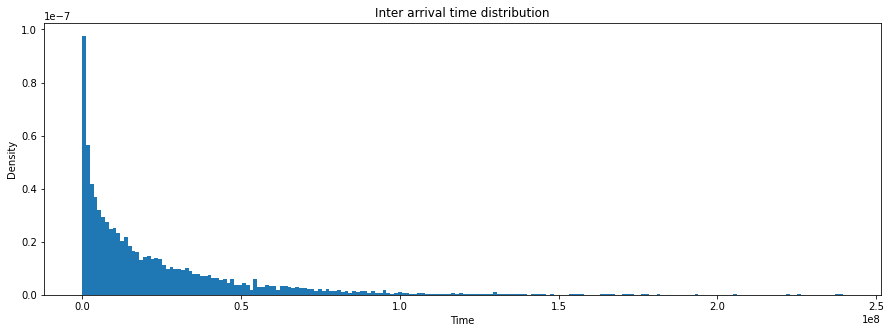

In [10]:
times = data['Time'].values

plt.figure(figsize=(15,5))
delta_times = times[1:] - times[:-1]
mean_delta = delta_times.mean()
h = plt.hist(delta_times, bins=200, density=True)
plt.title("Inter arrival time distribution")
plt.xlabel("Time")
plt.ylabel("Density")
plt.show()

One could also be interested in the spacial distribution of earthquakes: non-surprinsingly most of the events lie on three different lines, they which to the intersections of the tectonic plates below Japan.

**Note :** Spacial information was not used in the benchmark but carries valuable informations. We encourage the participants to find innovative ways to incorporate this information into their models.

<ipython-input-11-74ebf30f5977>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


(19.5069, 50.3266)

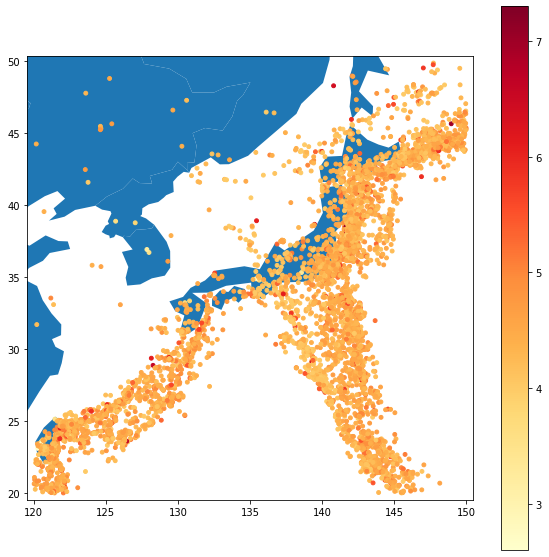

In [11]:
# Assuming 'data' is a DataFrame that includes 'Longitude' and 'Latitude' columns
geometry = [Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
gdf = GeoDataFrame(data, geometry=geometry)

# Load a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Calculate bounds of the GeoDataFrame
minx, miny, maxx, maxy = gdf.total_bounds

# Plotting
ax = world.plot(figsize=(10, 10))
gdf.plot(ax=ax, marker='o', column='Magnitude', markersize=15, cmap='YlOrRd', legend=True)

# Adjust the plotting range to center on the scatter
# You might want to add a small margin around the edges for better visualization
margin = 0.5  # Adjust this value based on your preference
ax.set_xlim(minx - margin, maxx + margin)
ax.set_ylim(miny - margin, maxy + margin)

This challenge primarily focuses on the self-exciting property of earthquake events. Although participants do not need an in-depth understanding of this concept, we include the following plot to demonstrate that this behavior indeed appears in the data. Intuitively, a process is self-exciting if the occurrence of past points increases the probability of future points occurring. Mathematically, a point process $N$ is called self-exciting if:
    $$cov(N(s,t),N(t,u))>0$$
for $s<t<u$ where here, $cov$ denotes the covariance of the two quantities. 

Below is the plot of the autocorelation of the Japanese earthquakes point process. The blue region represents the $95\%$ confidence interval around $0$. One can see that all fisrt $40$ autocorelations factors are statistically significant, which means that the data indeed exhibit a self-exciting behavior.

For more information about self-exciting point processes (and potential ideas to kickstart the challenge), we refer to [this quite extensive review](https://arxiv.org/pdf/1708.02647.pdf) . 

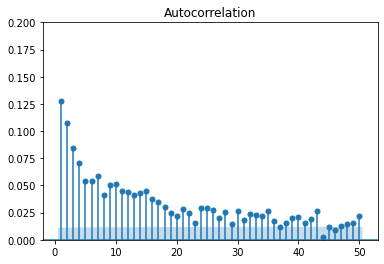

In [12]:
events_times = np.sort(data["Time"])

# Assuming `event_times` is a sorted NumPy array of event times
# Convert event times to counts per time bin for ACF analysis
time_bins = np.arange(events_times.min(), events_times.max(), 5000000)
event_counts = np.histogram(events_times, bins=time_bins)[0]

# Plot the ACF of event counts
plot_acf(event_counts, lags=50, alpha=0.05, zero=False) 
plt.ylim(0, 0.2)
plt.show()

Finally, it's worth noting that earthquakes can be classified in many different ways. One possible approach is to classify them by their level of danger. Below, we visualize the arrival times for each class of earthquakes and observe that small earthquakes occur much more frequently than strong ones.

In [13]:
def classify_magnitude(magnitude):
    if magnitude < 2:
        return 'tiny'
    elif 2 <= magnitude < 3:
        return 'very small'
    elif 3 <= magnitude < 4:
        return 'small'
    elif 4 <= magnitude < 5:
        return 'moderate'
    elif 5 <= magnitude < 6:
        return 'strong'
    else:
        return 'very strong'
    
data['Classification'] = data['Magnitude'].apply(classify_magnitude)

<AxesSubplot: >

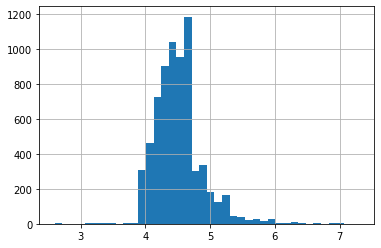

In [14]:
data["Magnitude"].hist(bins=40)

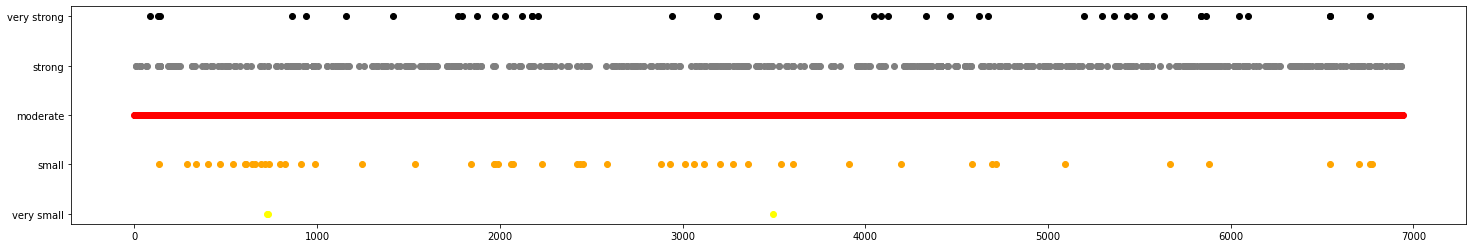

In [15]:
data = data.sort_values(["Magnitude"])
data["Time"] = data["Time"]/mean_delta
list_times = [data[data['Classification']==c]['Time'].values.astype(np.float64) for c in data['Classification'].unique()]

time_bins = np.arange(events_times.min(), events_times.max(), 5000000)
event_counts = [np.histogram(list_times[c], bins=time_bins)[0] for c in range(data['Classification'].nunique())]

label_encoder = LabelEncoder()
data['Classification_index'] = label_encoder.fit_transform(data['Classification']).astype(int)

plt.figure(figsize=(25,4))
colors = ['yellow', 'orange', 'red', 'grey', 'black']
for k in range(len(list_times)):
    plt.scatter(list_times[k], [k]*len(list_times[k]), color=colors[k])

# Set y-axis labels
classification_labels = ['very small', 'small', 'moderate', 'strong', 'very strong']
plt.yticks(range(len(classification_labels)), classification_labels)

plt.show()

As a benchmark, we provide a very basic Epidemic Type Aftershock Sequence (ETAS) model. This model, while fundamental, exhibits limited performance, presenting numerous opportunities for enhancement. Building upon this foundational model poses the challenge we leave to the participants! For more information about ETAS model, refer to [Yosihiko Ogata & al.](https://link.springer.com/article/10.1023/A:1003403601725).

In [16]:
#Fit the model to our data :

#Hawkes process for the earthquakes times
data = data.sort_values('Time')
timestamps = data['Time'].values

ExpoEstimator = SumExpHawkesProcessInference(P=5)

# Estimate paramters
mu_hat, eta_hat, theta_hat = ExpoEstimator.estimate_grid(timestamps, T=timestamps[-1], return_params=True)

print("Estimated Hawkes parameters : mu = {0}, eta = {1}, theta = {2}".format(mu_hat, eta_hat, theta_hat))

#Gaussian mixture model earthquakes magnitudes
magnitudes = data['Magnitude'].values.reshape(-1,1)

gmm = GaussianMixture(50)

#Estimate parameters 
gmm.fit(magnitudes)

Estimated Hawkes parameters : mu = 0.45885612814267646, eta = 0.5428131725732172, theta = [ 0.08705791  1.24853762  2.77977892 15.23473874 18.47615574]


/home/lucas/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:131: ConvergenceWarning: Number of distinct clusters (44) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  cluster.KMeans(


GaussianMixture(n_components=50)

### Submission Guidelines

Participants are required to submit a numpy array of shape (1700, 2) containing 1700 samples from their model. Each sample should consist of an arrival time and of a magnitude, thus should the array should be of the form `[[t1, m1], ..., [tn, mn]]`.

We provide the evaluation metric in the metrics.py file, as displayed below.

In [17]:
while True:
    #Simulation of the Hawkes process
    ExpoSimulator = SumExpHawkesProcessSimulation(mu=mu_hat, eta=eta_hat, theta_vec=theta_hat)

    T_samples = ExpoSimulator.simulate(3000, seed=42)*mean_delta #2000 units of time ensure that we generate enough points

    #Simulation of the Gaussian mixture

    M_samples = gmm.sample(len(T_samples))[0].reshape(1,-1)[0]
    #Generate submission
    samples = [[T_samples[k], M_samples[k]] for k in range(len(T_samples))]
    if len(samples) >= 1700:
        samples = samples[:1700]
        break
samples = np.array([np.array(s) for s in samples])
print("Succesfully generated {} samples.".format(len(samples)))

Succesfully generated 1700 samples.


In [18]:
from metrics import earthquake_simulation_metric

first_metric, second_metric, total_loss = earthquake_simulation_metric(samples)
print("Anderson Darling on the magnitudes : {0} \nW2 on the inter-arrivals and magnitudes : {1}".format(first_metric, second_metric))
print("Total loss : {}".format(total_loss))

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


/home/lucas/Documents/Etudes/Télécom/M2/Datacamp/group_project/earthquake_forecast/metrics.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_samples["Time"] = test_samples["Time"] - test_samples["Time"].min()


Anderson Darling on the magnitudes : 71.79106158153104 
W2 on the inter-arrivals and magnitudes : 22410749.34877173
Total loss : 22410821.13983331


## Evaluation Metrics

Evaluation of models will be based on two key metrics:
- The **Anderson-Darling** metric between the generated magnitudes and the empirical magnitudes in the training dataset. This metric emphasizes differences in the distributions' extremes, placing greater emphasis on the tails that represent higher magnitudes and more destructive earthquakes. Given a sample of magnitudes $M_1, ..., M_n$, let us denote its empirical cumulative distribution function ( or c.d.f.) as
$$
\widehat{F}_n(x) = \frac{1}{n}\sum_{i=1}^{n} \mathbb{I}\left\{ M_i \le x \right\}
$$
The Anderson-Darling distance (A.D. distance) has the following expression:
$$
W_n=n \int_{-\infty}^{\infty} \frac{\left(\widehat{F}_n(x)-F(x)\right)^2}{F(x)(1-F(x))} d F(x)
$$
which consists essentially in a weighted square difference between the theoretical cumulative distribution function of the considered distribution and the empirical c.d.f. of an i.i.d. sample with that same distribution. To evaluate the performance of submission we propose an empirical version of the Anderson-Darling distance. We refer to $M_{1, n} \leq \cdots \leq X_{n, n}$ as the order statistics. For a generated sample $\tilde{M}_i$ we define the following
$$
\tilde{u}_{i, n}=\frac{1}{n+2}\left(\sum_{j=1}^n \mathbb{I}\left\{M_j\leq \tilde{M}_{i, n}\right\}+1\right) \approx \widehat{F}_n^M(\tilde{M}_{i, n}) \approx \mathbb{P}_{M\sim\mu}\left( M \le \tilde{M}_{i, n} \right)
$$
which represents the model probability of a generated variable (with small corrections to avoid having $\tilde{u}_{i, n}=0,1$).
The way we compute the Anderson-Darling distance is then
$$
AD((M_1,\ldots M_n),(\tilde{M}_1,\ldots \tilde{M}_n))=-n-\frac{1}{n} \sum_{i=1}^n(2 i-1)\left(\log \left(\widetilde{u}_{i, n}^\tau\right)+\log \left(1-\widetilde{u}_{n-i+1, n}^\tau\right)\right).
$$

- The **Wassertein distance** of the generated inter-arrival times and magnitudes vector $(v_i)_i = ((T_{i}-T_{i-1},M_i,\cdots,T_{i+k-1}-T_{i+k-2},M_{i+k-1}))_i$, in $\mathbb{R}^{2k}$ and its empirical counterpart. This measurement ensures the model captures both the self-exciting properties of earthquake occurrences and the correlations between earthquake magnitudes and frequencies.


Denote $\mu_{M}$ the marginal distribution of the generated magnitudes, $\mu_{IA}$ the marginal distribution of the generated inter_arrival and magnitude vectors $(v_i)_i$, as well as $\hat{\mu}_{M}$ and $\hat{\mu}_{IA}$ their empirical couterparts in the test dataset. Then the final metric used to rank the participants is :
$$ \mathcal{L}(G) = AD(\mu_{M}, \hat{\mu_{M}}) + W_2(\mu_{IA}, \hat{\mu_{IA}})$$

The participants' goal should be to minimize $\mathcal{L}$.

For more details on any of these two metrics we refer to [Wikipedia:Anderson-Darling](https://en.wikipedia.org/wiki/Anderson%E2%80%93Darling_test) and [Wikipedia:W2](https://en.wikipedia.org/wiki/Wasserstein_metric). For for further details on the formulation of the Andesron-Darling distance in particular, we refer to [Asymptotic Theory of Certain "Goodness of Fit" Criteria Based on Stochastic Processes](https://projecteuclid.org/journals/annals-of-mathematical-statistics/volume-23/issue-2/Asymptotic-Theory-of-Certain-Goodness-of-Fit-Criteria-Based-on/10.1214/aoms/1177729437.full) and [Tests of Goodness-of-Fit](https://link.springer.com/referenceworkentry/10.1007/978-3-642-04898-2_118).